In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt


from pandas_datareader import data as pdr

from pandas_datareader import data as pdr

aapl = pdr.get_data_yahoo('AAPL', 
                          start=datetime.datetime(2010, 1, 1))
aapl.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,30.490000,30.642857,30.340000,30.572857,27.406532,123432400
2010-01-05,30.657143,30.798571,30.464285,30.625713,27.453915,150476200
2010-01-06,30.625713,30.747143,30.107143,30.138571,27.017223,138040000
2010-01-07,30.250000,30.285715,29.864286,30.082857,26.967278,119282800
2010-01-08,30.042856,30.285715,29.865715,30.282858,27.146566,111902700


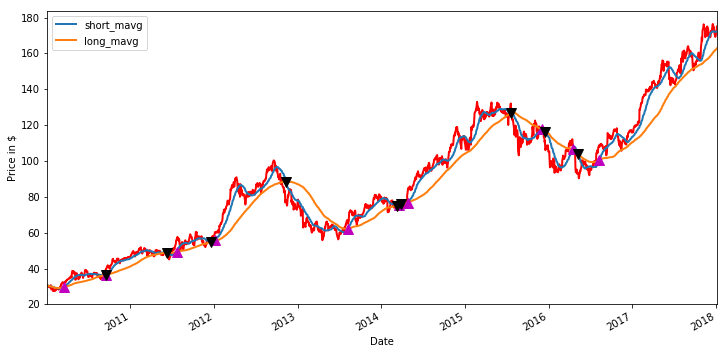

In [3]:
#build the tr st.
# Initialize the short and long windows
short_window = 30
long_window = 120

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=aapl.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = aapl['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = aapl['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()


# Initialize the plot figure
fig = plt.figure(figsize=(12,6))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
aapl['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

23535.2678


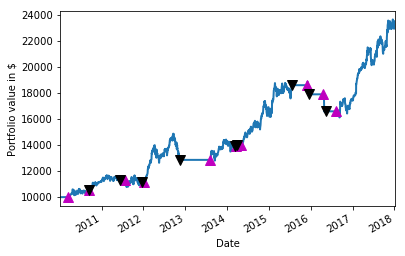

In [4]:
#backtest

# Set the initial capital
initial_capital= float(10000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['AAPL'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(aapl['Adj Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(aapl['Adj Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(aapl['Adj Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

print(portfolio['total'].iloc[-1])

import matplotlib.pyplot as plt

fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

# Plot the "buy" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')

# Plot the "sell" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()


9683.3588
27656.6406


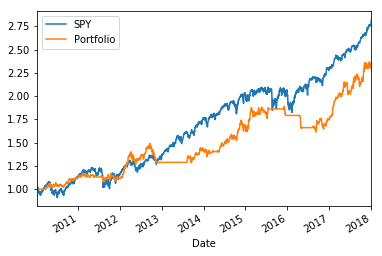

In [7]:
# Benchmarking

spyder = pdr.get_data_yahoo('SPY', 
                          start=datetime.datetime(2010, 1, 1))

spyder.iloc[[0,-1],:]
batch = 100      # Number of shares bought per batch
batches = 10000 // np.ceil(100 * spyder["Adj Close"].iloc[0]) # Maximum number of batches of stocks invested in
trade_val = batches * batch * spyder["Adj Close"].iloc[0] # How much money is used to buy SPY
print(trade_val)
final_val = batches * batch * spyder["Adj Close"].iloc[-1] + (10000 - trade_val) # Final value of the portfolio
print(final_val)
# We see that the buy-and-hold strategy beats the strategy we developed earlier. I would also like to see a plot.
ax_bench = (spyder["Adj Close"]/ spyder["Adj Close"].iloc[0]).plot(label = "SPY")
# Plot the equity curve in dollars
ax_bench = (portfolio['total'].groupby(level = 0).apply(lambda x: x[-1]) / 10000).plot(ax=ax_bench, label = "Portfolio")
#ax_bench = (bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]) / 100000).plot(ax = ax_bench, label = "Portfolio")
ax_bench.legend(ax_bench.get_lines(), [l.get_label() for l in ax_bench.get_lines()], loc = 'best')
plt.show()